<a href="https://colab.research.google.com/github/prog815/portfOptim/blob/master/%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D0%B0%D1%8F_%D1%82%D0%BE%D1%87%D0%BA%D0%B0_%D0%B8_%D0%BE%D1%82%D1%80%D1%8B%D0%B2_%D0%BE%D1%82_%D1%80%D0%B0%D0%B2%D0%BD%D0%BE%D0%B2%D0%B5%D1%81%D0%BD%D0%BE%D0%B3%D0%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Случайная точка и отрыв от равновесного

Проект "Оптимизация инвестиционного портфеля".

https://github.com/prog815/portfOptim

Енин А.В.

Оренбург - 2020

25.09.2020

Ищем оптимальные гиперпараметры в случайных точках. Дополнительно отнимаем результат равновесной модели.

# Подготовка

## Подгружаем библиотеки

In [ ]:
!pip install bt

In [ ]:
import bt
import pandas as pd
import seaborn
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/ffn/core.py:27: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)
/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
%matplotlib inline

In [ ]:
! pip install git+https://github.com/prog815/portfOptim

  Cloning https://github.com/prog815/portfOptim to /tmp/pip-req-build-v92yxkb_
  Running command git clone -q https://github.com/prog815/portfOptim /tmp/pip-req-build-v92yxkb_
  Created wheel for portfOptim: filename=portfOptim-0.0.4-cp36-none-any.whl size=4077 sha256=899468105ae02e1b9c803c2a0573f6a24d7e665745bd8c017891b11afe24fceb
  Stored in directory: /tmp/pip-ephem-wheel-cache-9ah48xx5/wheels/ef/8b/25/89eadb83696c6f13f7c19550677e232c32182db7884471ca86
Successfully built portfOptim


In [ ]:
import portfOptim

## Подгружаем историю котировок

In [ ]:
# fetch some data
data = bt.get(['AAPL','GE','BAC','AMD','PLUG','F'], start='2010-01-01')
print( data.head())

                aapl         ge        bac   amd  plug         f
Date                                                            
2010-01-04  6.604801  10.840267  13.816905  9.70   7.0  6.937616
2010-01-05  6.616219  10.896401  14.266021  9.71   7.0  7.396526
2010-01-06  6.510980  10.840267  14.433337  9.57   6.7  7.673220
2010-01-07  6.498945  11.401575  14.908874  9.47   6.7  7.868933
2010-01-08  6.542150  11.647147  14.776777  9.43   6.8  7.889179


# Поиск оптимальных параметров

## Подгружаем библиотеку генетической оптимизации

In [ ]:
! pip install git+https://github.com/prog815/progGA

  Cloning https://github.com/prog815/progGA to /tmp/pip-req-build-q3eerx9u
  Running command git clone -q https://github.com/prog815/progGA /tmp/pip-req-build-q3eerx9u
  Created wheel for progGA: filename=progGA-0.0.7-cp36-none-any.whl size=3733 sha256=9a54b6280976b0691b805dfcc732e40243be313abcf85b955d7319674808e49e
  Stored in directory: /tmp/pip-ephem-wheel-cache-hvsntgsa/wheels/9c/7a/cc/d1ffa9ccaa42befda21d63d0e01c942a0add5854c37e0bd2ff
Successfully built progGA


In [ ]:
from progGA import ListGenetic

## Определяем функцию качества (коэффициент шарпа)

### Относительные изменения

In [ ]:
dData = data.pct_change()
dData

,aapl,ge,bac,amd,plug,f
Date,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.001729,0.005178,0.032505,0.001031,0.000000,0.066148
2010-01-06,-0.015906,-0.005152,0.011728,-0.014418,-0.042857,0.037409
2010-01-07,-0.001848,0.051780,0.032947,-0.010449,0.000000,0.025506
2010-01-08,0.006648,0.021538,-0.008860,-0.004224,0.014925,0.002573
...,...,...,...,...,...,...
2020-09-21,0.030326,-0.077035,-0.029353,0.040171,-0.014749,-0.049793
2020-09-22,0.015716,-0.015748,-0.021659,-0.003079,-0.032186,-0.013100
2020-09-23,-0.041946,-0.022400,-0.028404,-0.038224,-0.065739,-0.020649


### Сама функция

In [ ]:
#%%time

allLen = dData.shape[0]

allLen //= 2

validLen = 10

def getQualityMethod(lookback):
    
    # случайная точка
    randPoint = np.random.randint(lookback,allLen-validLen)

    # выборки
    learnData = dData.iloc[(randPoint-lookback):randPoint]
    validData = dData.iloc[randPoint:(randPoint+validLen)]

    # ковариация и доходность на обучении
    learnCov = learnData.cov().values
    learnDoh = learnData.mean().values

    # оптимальные веса
    weights = portfOptim.portfSharpOptim(learnDoh,learnCov)

    # ковариация и доходность на отборе
    validCov = validData.cov().values
    validDoh = validData.mean().values

    # коэффициент Шарпа на отборе для оптимальной стратегии
    optimRes = portfOptim.koefSharp(weights,validDoh,validCov)

    # коэффициент Шарпа на отборе для равновесной стратегии
    eqRes = portfOptim.koefSharp(np.ones_like(weights)/len(weights),validDoh,validCov)

    # возвращаем разницу коэффициентов
    return optimRes - eqRes

#getQualityMethod(100)

## Создаем модель оптимизации

In [ ]:
modelGA = ListGenetic(lookback=range(10,400),
                      quality_method=getQualityMethod)

## Ищем лучшие парметры оптимизируя в генетике

In [ ]:
modelGA.fit(15000)

15194 {'quality': -0.11608875612842773, 'lookback': 209}
15406 {'quality': 0.22447722857226182, 'lookback': 210}
15617 {'quality': -0.09505780171571696, 'lookback': 204}
15827 {'quality': 0.019909253217707222, 'lookback': 226}
16028 {'quality': 0.13005230160872094, 'lookback': 224}
16236 {'quality': 0.23124352911524743, 'lookback': 230}
16443 {'quality': 0.4246513484383889, 'lookback': 253}
16651 {'quality': 0.009790626643808628, 'lookback': 232}
16854 {'quality': 0.01755851334098857, 'lookback': 234}
17061 {'quality': 0.2172662969542576, 'lookback': 254}
17263 {'quality': 0.4330743104664825, 'lookback': 213}
17460 {'quality': -0.499045837842934, 'lookback': 248}
17668 {'quality': 0.18921310418873524, 'lookback': 267}
17879 {'quality': -0.17060035012220118, 'lookback': 246}
18088 {'quality': 0.180042180549422, 'lookback': 242}
18297 {'quality': 0.128445499755158, 'lookback': 239}
18509 {'quality': -0.3992863787955582, 'lookback': 237}
18708 {'quality': 0.3228396679356716, 'lookback': 2

## Динамика параметров

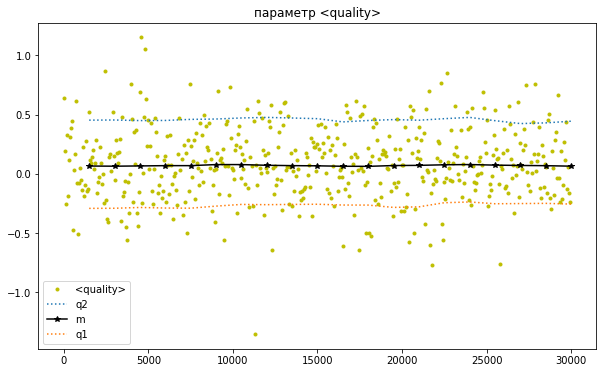

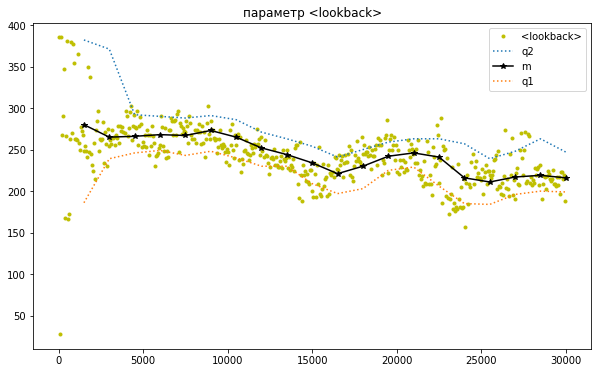

In [ ]:
modelGA.plot_hist_new(('quality','lookback'))

## Оптимальные гиперпараметры

In [ ]:
modelGA.getBestParams()

{'lookback': 208}

# Бэктест с оптимальными параметрами

## Стратегия

In [ ]:
lookback_best = modelGA.getBestParams()['lookback']
lookback_best

208

In [ ]:
validLen

10

### Равновесная

In [ ]:
s_eq = bt.Strategy('равновесный', [bt.algos.RunEveryNPeriods(validLen,offset=lookback_best),
                                 bt.algos.SelectAll(),
                                 bt.algos.WeighEqually(),
                                 bt.algos.Rebalance()])
test_eq = bt.Backtest(s_eq, data)

### Оптимальная

In [ ]:
s_op = bt.Strategy('оптимальный', [bt.algos.RunEveryNPeriods(validLen,offset=lookback_best),
                                bt.algos.SelectAll(),
                                bt.algos.WeighMeanVar(lookback=pd.DateOffset(days=lookback_best)),
                                bt.algos.Rebalance()])
test_op = bt.Backtest(s_op, data)

## Прогон

In [ ]:
res = bt.run(test_eq,test_op)

равновесный
0% [############################# ] 100% | ETA: 00:00:00оптимальный
0% [############################# ] 100% | ETA: 00:00:00

## Динамика балансов

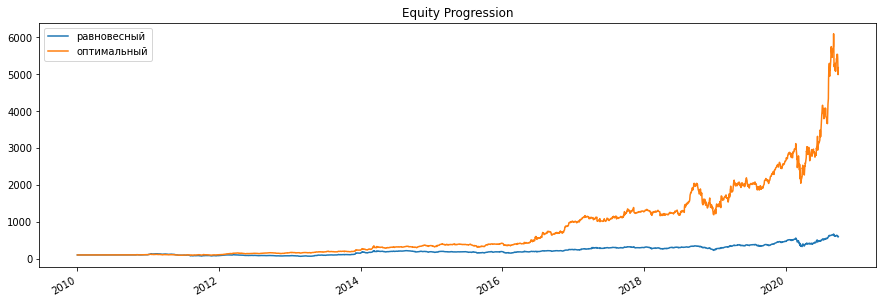

In [ ]:
res.plot()

## Динамика долей оптимального

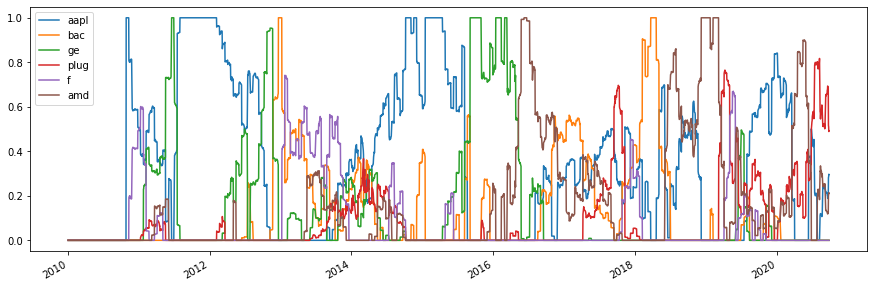

In [ ]:
res.plot_security_weights(1)

## Итоги обеих стратегий

In [ ]:
res.display()

Stat                 равновесный    оптимальный
-------------------  -------------  -------------
Start                2010-01-03     2010-01-03
End                  2020-09-25     2020-09-25
Risk-free rate       0.00%          0.00%

Total Return         494.87%        5071.67%
Daily Sharpe         0.72           1.26
Daily Sortino        1.18           2.15
CAGR                 18.08%         44.46%
Max Drawdown         -53.16%        -41.81%
Calmar Ratio         0.34           1.06

MTD                  -8.81%         -10.12%
3m                   20.55%         49.54%
6m                   55.58%         112.45%
YTD                  26.54%         93.74%
1Y                   58.78%         142.65%
3Y (ann.)            24.50%         62.01%
5Y (ann.)            29.97%         73.18%
10Y (ann.)           19.53%         48.40%
Since Incep. (ann.)  18.08%         44.46%

Daily Sharpe         0.72           1.26
Daily Sortino        1.18           2.15
Daily Mean (ann.)    20.87%         